## Setup and get data

In [1]:
# Kaggle dataset bootstrapping
OWNER_NAME = 'asdasdasasdas/'
DATASET_NAME = 'garbage-classification'

!pip install -qq kaggle

import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# get dataset data
if iskaggle:
    path = Path('../input/'+DATASET_NAME)
else:
    DOWNLOADS = Path('downloads')
    import zipfile,kaggle
    path = DOWNLOADS / DATASET_NAME
    if not path.is_dir():
        print('about to download', OWNER_NAME+DATASET_NAME, 'to', DOWNLOADS)
        kaggle.api.dataset_download_files(OWNER_NAME+DATASET_NAME, path=DOWNLOADS)
        print('about to unzip', f'{path}.zip', 'to', path)
        zipfile.ZipFile(f'{path}.zip').extractall(path)
print('done')

done


In [2]:
!ls {path}

'Garbage classification'	       one-indexed-files-notrash_val.txt
'garbage classification'	       one-indexed-files.txt
 one-indexed-files-notrash_test.txt    zero-indexed-files.txt
 one-indexed-files-notrash_train.txt


In [3]:
path = path / 'Garbage classification'
!ls "{path}"

'Garbage classification'


In [4]:
path = path / 'Garbage classification'
!ls "{path}"

cardboard  glass  metal  paper	plastic  trash


## Data preprocessing

In [6]:
!pip install -qq timm
!pip install -qq fastai
!pip install -qq pynvml

import timm 
from fastai.vision.all import *

files = get_image_files(path)
len(files)

2527

In [8]:
categories = list(p.name for p in path.iterdir())
categories

['metal', 'trash', 'glass', 'cardboard', 'paper', 'plastic']

In [9]:
for c in categories:
    print(c, len(list((path/c).iterdir())))

metal 410
trash 137
glass 501
cardboard 403
paper 594
plastic 482


In [10]:
from fastcore.parallel import *

def get_image_size(o): return PILImage.create(o).size
sizes = parallel(get_image_size, files, n_workers=8)
pd.Series(sizes).value_counts()

(512, 384)    2527
dtype: int64

## Fast training of a simple model to understand data

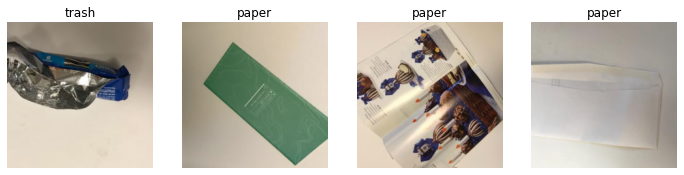

In [42]:
dls = ImageDataLoaders.from_folder(path, 
        valid_pct=0.2,
        item_tfms=Resize(384),
        batch_tfms=aug_transforms(size=224, min_scale=0.75),
        bs=64)
dls.show_batch(nrows=1, ncols=4)

In [57]:
learn = vision_learner(dls, resnet50, metrics=[error_rate, accuracy]).to_fp16()
learn.fine_tune(3, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.959916,2.165244,0.833663,0.166337,00:08
1,2.845907,1.998756,0.776238,0.223762,00:08
2,2.690179,1.713455,0.679208,0.320792,00:08


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.334031,1.644743,0.675248,0.324752,00:09
1,2.291889,1.570400,0.623762,0.376238,00:09
2,2.263443,1.558589,0.623762,0.376238,00:09


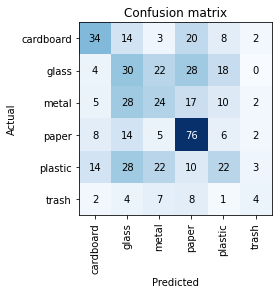

In [58]:
# Let's see what the problematic classes are
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

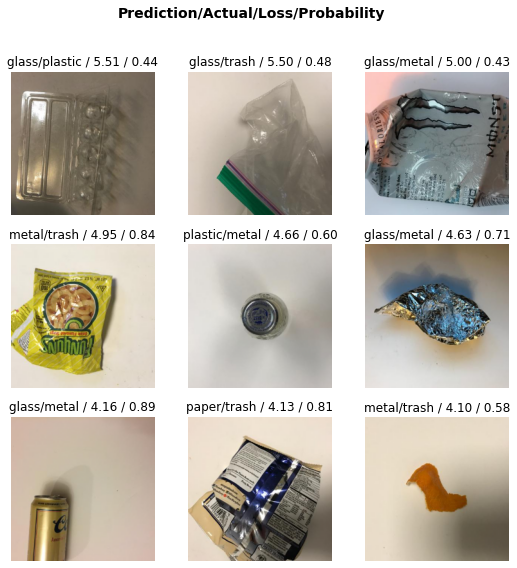

In [61]:
# And now the problematic images...
interp.plot_top_losses(9, nrows=3)

In [63]:
# can we clean up data?
from fastai.vision.widgets import *
import ipywidgets as widgets

cleaner = ImageClassifierCleaner(learn)
cleaner

## Now let's try some bigger models

In [78]:
import gc
!pip install -Uqq pynvml
def free_gpu():
    gc.collect()
    torch.cuda.empty_cache()
    return 'done'
    
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    free_gpu()

In [11]:
# we only use the smolest category to see GPU memory usage of each model 
fast_train_folder = path / 'trash'

def gpu_memory_fast_train(arch, size=(512,384), accum=1, ebs=64, epochs=1):
    # effective batch size of 64, and accum=2 gives real batch_size=32
    batch_size = ebs//accum
    
    dls = ImageDataLoaders.from_folder(fast_train_folder, 
        valid_pct=0.2,
        batch_tfms=aug_transforms(size=size, min_scale=0.75),
        bs=batch_size)
    
    training_cbs = GradientAccumulation(ebs) if accum else []
    
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=training_cbs).to_fp16()
    learn.unfreeze()
    learn.fit_one_cycle(epochs, 0.01)

In [12]:
free_gpu()
gpu_memory_fast_train('convnext_large_in22k', accum=32)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:09


GPU:0
process       5434 uses     1805.000 MB GPU memory
process      10585 uses     7031.000 MB GPU memory


In [56]:
gpu_memory_fast_train('resnet152', accum=2)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:03


GPU:0
process      30473 uses    15305.000 MB GPU memory


## Running a big model for real

In [66]:
# we use full training images now
trn_path = path
tst_files = None # for now
trn_path

Path('downloads/garbage-classification/Garbage classification/Garbage classification')

In [98]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
            get_items=get_image_files, 
            splitter=RandomSplitter(valid_pct=0.2),
            get_y=parent_label,
            item_tfms=Resize(384),
            batch_tfms=aug_transforms(size=224, min_scale=0.75))

def create_model(arch, accum, ebs=64):
    batch_size = ebs//accum
    training_cbs = GradientAccumulation(ebs) if accum else []
    
    # create image data loaders
    dls = dblock.dataloaders(path, bs=batch_size)
    
    # create vision learner
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=training_cbs).to_fp16()
    
    return learn

In [104]:
free_gpu()

'done'

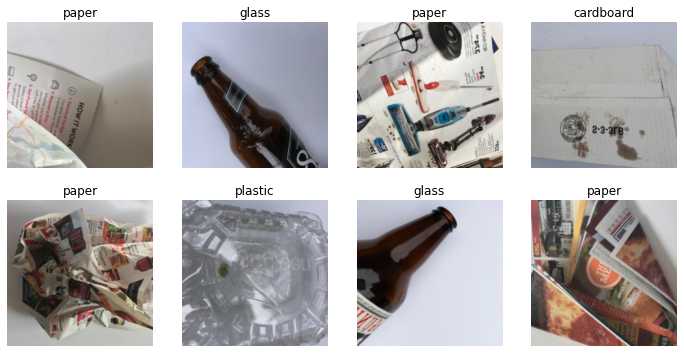

In [105]:
learn = create_model('convnext_small_in22k', accum=4)
learn.dls.show_batch(nrows=2, ncols=4, unique=False)

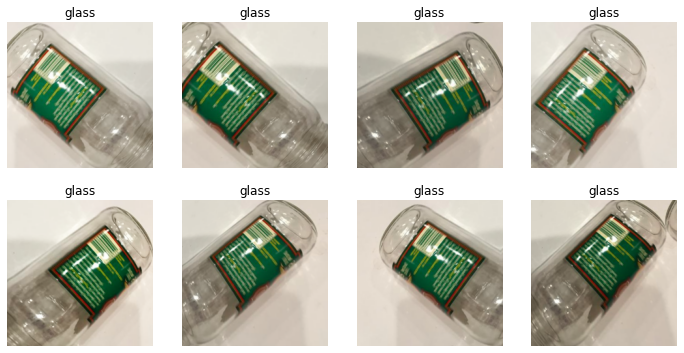

In [106]:
learn.dls.show_batch(nrows=2, ncols=4, unique=True)

SuggestedLRs(valley=0.02754228748381138)

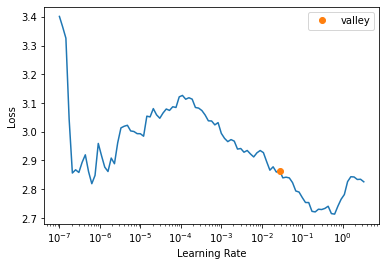

In [107]:
learn.lr_find()

In [108]:
report_gpu()

GPU:0
process      10585 uses    13759.000 MB GPU memory


In [115]:
# let's fine tune it!!!
epochs = 15
learn.fine_tune(epochs, base_lr=0.09)

epoch,train_loss,valid_loss,error_rate,time
0,1.823188,5.537321,0.867327,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.756791,0.522230,0.184158,00:14
1,0.665308,0.417233,0.142574,00:14
2,0.584376,0.347241,0.110891,00:14
3,0.509234,0.325306,0.110891,00:15
4,0.443816,0.285589,0.097030,00:14
5,0.440637,0.269529,0.097030,00:14
6,0.397117,0.247817,0.089109,00:14
7,0.354420,0.250434,0.089109,00:14
8,0.369448,0.246718,0.100990,00:14
9,0.343810,0.212814,0.079208,00:14


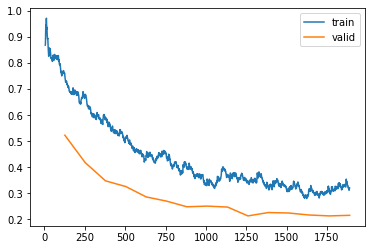

In [116]:
learn.recorder.plot_loss()

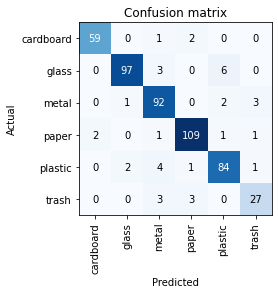

In [117]:
# Let's see what the problematic classes are
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

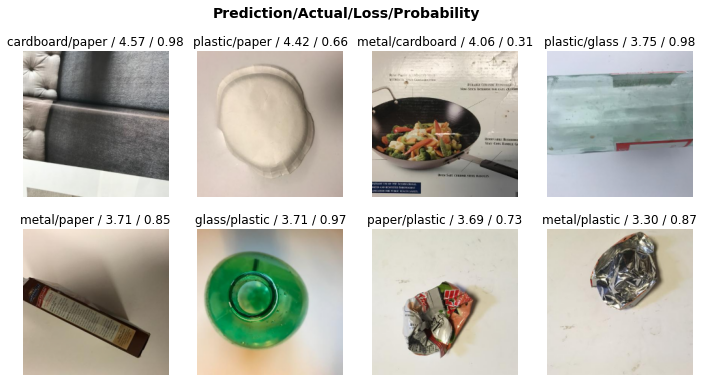

In [118]:
interp.plot_top_losses(8)

In [119]:
interp.print_classification_report()

              precision    recall  f1-score   support

   cardboard       0.97      0.95      0.96        62
       glass       0.97      0.92      0.94       106
       metal       0.88      0.94      0.91        98
       paper       0.95      0.96      0.95       114
     plastic       0.90      0.91      0.91        92
       trash       0.84      0.82      0.83        33

    accuracy                           0.93       505
   macro avg       0.92      0.92      0.92       505
weighted avg       0.93      0.93      0.93       505



In [126]:
save_pickle('models/garbage-recognizer-convnext_small_in22k-15-epochs.pkl', learn)